# 01 - Embeddings Preparation

Notebook scope:
- load dataset/config via shared helpers
- build vocabulary and analyse coverage (Q1a/Q1b)
- prepare OOV mitigation experiments (Q1c)
- stage embedding visualisation workflow (Q1d)

_Heavy lifting stays in `src/`; this notebook should read like a report._


## Imports & dataset setup

Establish a consistent configuration-driven pipeline. Keep raw outputs minimal so plots/tables remain easy to lift into the final report.


In [4]:
from pathlib import Path

from src.config import load_data_config
from src.dataset_pipeline import prepare_tokenised_splits
from src.embeddings import load_torchtext_glove
from src.reports import build_vocabulary_report, compute_oov_report, top_tokens_by_label
from src.plotting import plot_top_tokens_projection

data_config = load_data_config(Path("configs/data.yaml"))
splits = prepare_tokenised_splits(data_config)
len(splits.train), len(splits.validation), len(splits.test)


(4361, 1091, 500)

## Q1a - Vocabulary size

- Reuse `build_vocabulary_report` for corpus statistics.
- Persist intermediate artifacts (e.g., token frequencies) under `logs/` for reproducibility.


In [5]:
vocab_report = build_vocabulary_report(
    tokenised_dataset=splits.train,
    min_freq=data_config.vocabulary_min_freq,
    specials=data_config.vocabulary_specials,
)
vocab_report.summary()


{'documents': 4361,
 'total_tokens': 45591,
 'unique_tokens': 7477,
 'vocabulary_size': 7479,
 'min_frequency_threshold': 1}

## Q1b - OOV analysis

- Compare vocabulary against chosen embedding index via `compute_oov_report`.
- Produce per-class OOV counts using the helper's `per_label_summary()`.


In [6]:
embedding_result = load_torchtext_glove(
    vocabulary=vocab_report.vocabulary,
    name="6B",
    dim=100,
    trainable=True,
    random_seed=7,
)
oov_report = compute_oov_report(
    tokenised_dataset=splits.train,
    special_tokens=data_config.vocabulary_specials,
    embedding_result=embedding_result,
)
oov_report.summary()


.vector_cache/glove.6B.zip: 862MB [17:53, 803kB/s]                                
100%|█████████▉| 399999/400000 [00:05<00:00, 77190.96it/s]


{'unique_oov_words': 197,
 'oov_token_occurrences': 215,
 'mitigated_vectors': 199}

In [7]:
oov_report.per_label_summary()


[{'label': 'ABBR:exp', 'unique_oov_words': 3, 'oov_token_occurrences': 4},
 {'label': 'DESC:def', 'unique_oov_words': 40, 'oov_token_occurrences': 40},
 {'label': 'DESC:desc', 'unique_oov_words': 11, 'oov_token_occurrences': 11},
 {'label': 'DESC:manner', 'unique_oov_words': 10, 'oov_token_occurrences': 10},
 {'label': 'DESC:reason', 'unique_oov_words': 10, 'oov_token_occurrences': 11},
 {'label': 'ENTY:animal', 'unique_oov_words': 3, 'oov_token_occurrences': 3},
 {'label': 'ENTY:color', 'unique_oov_words': 1, 'oov_token_occurrences': 1},
 {'label': 'ENTY:cremat', 'unique_oov_words': 10, 'oov_token_occurrences': 13},
 {'label': 'ENTY:dismed', 'unique_oov_words': 3, 'oov_token_occurrences': 3},
 {'label': 'ENTY:food', 'unique_oov_words': 5, 'oov_token_occurrences': 5},
 {'label': 'ENTY:other', 'unique_oov_words': 21, 'oov_token_occurrences': 21},
 {'label': 'ENTY:product', 'unique_oov_words': 3, 'oov_token_occurrences': 4},
 {'label': 'ENTY:sport', 'unique_oov_words': 3, 'oov_token_occu

### OOV distribution
Tabular view before plotting for clarity.


In [8]:
import pandas as pd

per_label_df = pd.DataFrame(oov_report.per_label_summary())
per_label_df


,label,unique_oov_words,oov_token_occurrences
0,ABBR:exp,3,4
1,DESC:def,40,40
2,DESC:desc,11,11
3,DESC:manner,10,10
4,DESC:reason,10,11
5,ENTY:animal,3,3
6,ENTY:color,1,1
7,ENTY:cremat,10,13
8,ENTY:dismed,3,3
9,ENTY:food,5,5


### OOV histogram
Visualising per-label OOV occurrences.


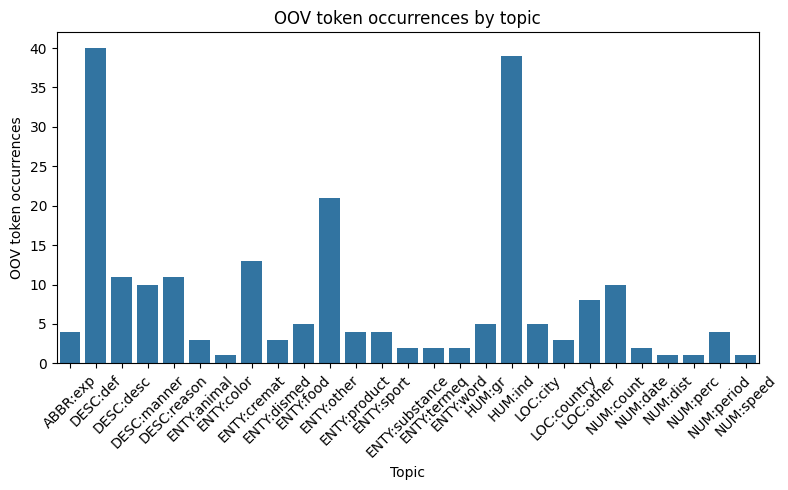

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=per_label_df, x="label", y="oov_token_occurrences")
plt.title("OOV token occurrences by topic")
plt.xlabel("Topic")
plt.ylabel("OOV token occurrences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Q1c - Mitigation strategy

- Compute the global mean of all in-vocabulary embeddings (excluding unknowns).
- Assign that mean vector to every OOV token before training.
- Keep the embeddings trainable.


In [10]:
from IPython.display import Markdown, display
mitigated_count = len(embedding_result.mitigated_tokens)
sample_tokens = list(embedding_result.mitigated_tokens.keys())[:10]
display(Markdown(f"Mitigated vectors generated for {mitigated_count} OOV tokens using the global mean. Example tokens: {', '.join(sample_tokens)}."))


Mitigated vectors generated for 199 OOV tokens using the global mean. Example tokens: -lantern, .., .dbf, 000th, 10-, 12601, 187s, 2th, 36893, 45mhz.

## Q1d - Embedding visualisation

- Use `plot_top_tokens_projection` to render scatter plots from the pre-computed token sets.
- Save figures under `plots/` for later inclusion in the report.


### Top tokens per topic
Preparing tokens for visualisation.


In [11]:
from spacy.lang.en.stop_words import STOP_WORDS

top_tokens = top_tokens_by_label(
    tokenised_dataset=splits.train,
    top_k=20,
    stopwords=set(STOP_WORDS),
)


### PCA projection
Legend placed below to reduce clutter.


,x,y,token,label
0,-2.322590,-2.415650,?,ENTY:cremat
1,-1.593940,-2.728803,`,ENTY:cremat
2,-0.483733,-0.326459,film,ENTY:cremat
3,-1.410334,1.121468,",",ENTY:cremat
4,0.522386,-1.003372,novel,ENTY:cremat


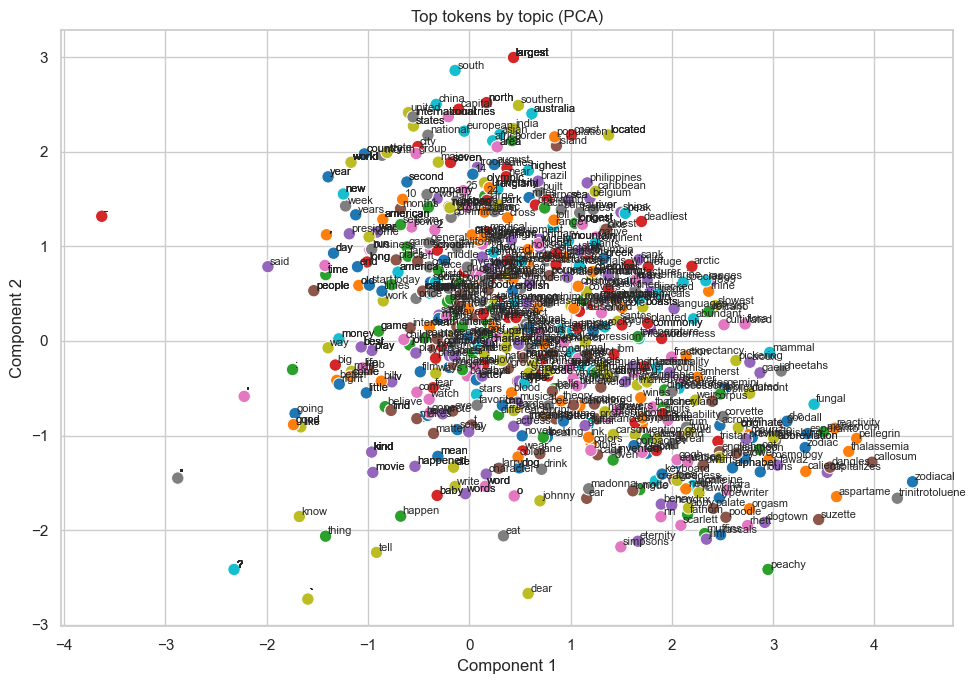

In [12]:
projection_frame_pca, _, _ = plot_top_tokens_projection(
    tokens_by_label=top_tokens,
    vocabulary=vocab_report.vocabulary,
    embedding_matrix=embedding_result.matrix,
    method="pca",
    title="Top tokens by topic (PCA)",
    output_path=Path("plots/part1_top_tokens_pca.png"),
    annotate_tokens=True,
    legend_location="none",
)
projection_frame_pca.head()


### t-SNE projection
Lower-dimensional view via t-SNE (perplexity 20).


,x,y,token,label
0,40.816422,-82.829460,?,ENTY:cremat
1,126.273407,-14.791553,`,ENTY:cremat
2,-2.994608,-16.223875,film,ENTY:cremat
3,-103.907921,38.536720,",",ENTY:cremat
4,3.293426,-7.844254,novel,ENTY:cremat


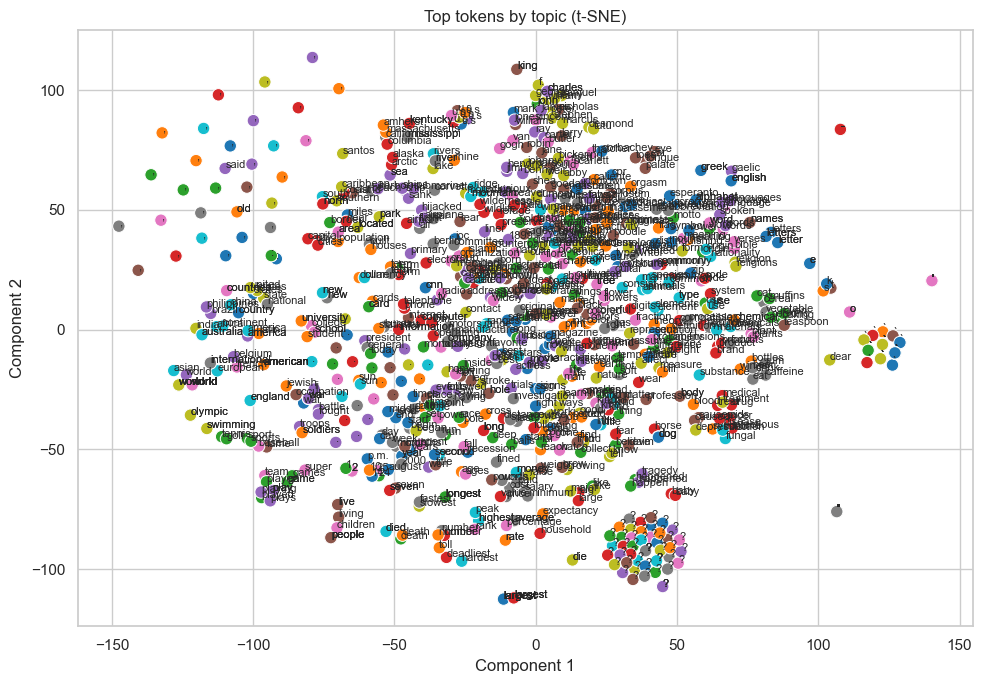

In [13]:
projection_frame_tsne, _, _ = plot_top_tokens_projection(
    tokens_by_label=top_tokens,
    vocabulary=vocab_report.vocabulary,
    embedding_matrix=embedding_result.matrix,
    method="tsne",
    title="Top tokens by topic (t-SNE)",
    output_path=Path("plots/part1_top_tokens_tsne.png"),
    annotate_tokens=True,
    legend_location="none",
    tsne_perplexity=15.0, #tried out a couple of different perplexities 
)
projection_frame_tsne.head()
